In [1]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import time
import rebound
import xgboost as xgb
import sklearn
import os
from sklearn.model_selection import cross_val_score
import pickle
import cPickle

/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This is first checking the affects of a changing lyapunov window

In [2]:
#data_files = os.listdir()

data_L_10 = pd.read_csv("../csvs/sifOrbs=1000.0Nout=100window=10lyapwindow=10.csv", index_col=0)
data_L_5 = pd.read_csv("../csvs/sifOrbs=1000.0Nout=100window=10lyapwindow=5.csv", index_col=0)
data_L_20 = pd.read_csv("../csvs/sifOrbs=1000.0Nout=100window=10lyapwindow=20.csv", index_col=0)
data_L_50 = pd.read_csv("../csvs/sifOrbs=1000.0Nout=100window=10lyapwindow=50.csv", index_col=0)
data_L_100 = pd.read_csv("../csvs/Ignore/sifOrbs=10000.0Nout=100window=10lyapwindow=100.csv", index_col=0)

data_L_10.head()

,runstring,t_final_short,Rel_Eerr_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,...,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time,wall_time,Stable,instability_time,Rel_Eerr
0,0000000.bin,1000.0,1.685900e-08,1.000186,0.000383,1.001325,0.999690,0.000382,0.001139,0.000397,...,0.283495,0.000804,0.099917,0.004461,-4.550069e-09,498.172786,1.049691,0.0,1.235644e+07,1.099985e-04
1,0000001.bin,1000.0,3.951208e-08,1.000223,0.000272,1.001385,0.999928,0.000272,0.001161,0.000142,...,0.161194,0.001317,0.251954,0.235480,3.690566e-11,561.638532,1.053304,0.0,1.348749e+05,1.388587e-08
2,0000002.bin,1000.0,7.106941e-07,0.998432,0.001887,1.002179,0.995653,0.001890,0.003753,0.001577,...,0.035012,0.000116,0.008301,0.006980,1.129681e-10,582.309925,1.040091,0.0,1.276381e+04,3.048261e-04
3,0000003.bin,1000.0,1.408400e-09,1.000006,0.000024,1.000104,0.999986,0.000024,0.000098,0.000019,...,0.514998,0.000454,0.301741,0.297554,-7.120011e-11,6934.449662,0.987406,1.0,1.000000e+09,6.492574e-10
4,0000004.bin,1000.0,2.413914e-04,0.999908,0.000563,1.000964,0.998426,0.000563,0.001482,0.000322,...,0.280696,0.179040,0.501270,0.181689,-8.570641e-08,445.578373,1.045580,0.0,8.791888e+01,9.336734e-07


In [3]:
#"['daOverRH1' 'daOverRH2' 'mindaOverRH' 'maxdaOverRH' 'norm_LyapunovTime']"
features = []
features += ['avg_iH1', 'avg_iH2']
#features += ['mindaOverRH', 'maxdaOverRH']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
#features += ['Lyapunov_time']
features2= features[:] + ['Lyapunov_time']
print len(features), len(features2)
data_files = [data_L_5, data_L_10, data_L_20, data_L_50, data_L_100]
X_vals = []
Y_vals = []
X_vals_Lya = []
for i, data in enumerate(data_files):
    Y_vals.append(data["Stable"])
    data_feats =data[features]
    X_vals.append(data_feats)
    X_vals_Lya.append(data[features2])


29 30


In [3]:
#define the parametsr and model
min_child_w = 3
n_est=100
max_d = 8
learning_r = 0.01
model2 = xgb.XGBClassifier(min_child_weight=min_child_w, n_estimators=n_est, max_depth=max_d, learning_rate=learning_r)
params = model2.get_xgb_params()

In [5]:
start = time.time()
scores = []
wall_time = []
lyapunov_scores=[]
for i, data in enumerate(X_vals):
    print data.shape
    dtrain = xgb.DMatrix(X_vals[i], label=Y_vals[i])
    score = xgb.cv(params, dtrain, metrics = "auc", nfold=5, verbose_eval=True)
    # cross_val_score(estimator=model2, n_jobs=-1, cv = 5, X = X_vals[i], y = Y_vals[i], scoring ='average_precision', verbose = 5)
    print np.mean(score['test-auc-mean'])    #scores.append(score)
    scores.append(np.mean(score['test-auc-mean']))
    wall_time.append( np.mean(data_files[i]["wall_time"]))
    
    dtrain = xgb.DMatrix(X_vals_Lya[i], label=Y_vals[i])
    score = xgb.cv(params, dtrain, metrics = "auc", nfold=5, verbose_eval=True)
    # cross_val_score(estimator=model2, n_jobs=-1, cv = 5, X = X_vals[i], y = Y_vals[i], scoring ='average_precision', verbose = 5)
    print np.mean(score['test-auc-mean'])    #scores.append(score)
    lyapunov_scores.append(np.mean(score['test-auc-mean']))
end = time.time()
#print "Time Taken",  (end - start)

(24999, 29)
[0]	train-auc:0.966767+0.00108009	test-auc:0.947922+0.0027537
[1]	train-auc:0.968609+0.00112729	test-auc:0.949767+0.00312749
[2]	train-auc:0.969752+0.000723237	test-auc:0.951229+0.00237199
[3]	train-auc:0.970425+0.000820562	test-auc:0.951872+0.00253856
[4]	train-auc:0.971484+0.00148836	test-auc:0.952845+0.00289139
[5]	train-auc:0.971797+0.00112761	test-auc:0.953335+0.00257452
[6]	train-auc:0.972912+0.00161781	test-auc:0.954785+0.00296994
[7]	train-auc:0.973675+0.00149462	test-auc:0.955627+0.00250785
[8]	train-auc:0.974435+0.00140902	test-auc:0.95655+0.00230586
[9]	train-auc:0.974761+0.00142018	test-auc:0.956773+0.00224627
0.95307054
[0]	train-auc:0.966904+0.00109211	test-auc:0.947879+0.00337584
[1]	train-auc:0.968558+0.00134493	test-auc:0.949628+0.00348467
[2]	train-auc:0.96986+0.00094244	test-auc:0.95105+0.00283498
[3]	train-auc:0.970455+0.00116115	test-auc:0.951748+0.00319221
[4]	train-auc:0.971582+0.00182795	test-auc:0.952716+0.00356476
[5]	train-auc:0.971934+0.00148892	

NameError: name 'start' is not defined

We can conclude from the results above that altering the Lyapunov smoothing window did not seem to affect the results significantly. Based on that, the dataset bleow should still have decent score, even though the Lyapunov time is the same for all of them . Oddly enough, it seems to do best on this one. 

ValueError: x and y must be the same size

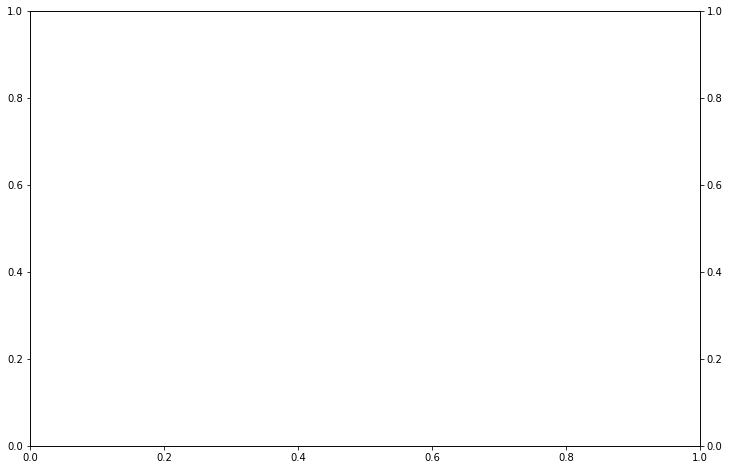

In [13]:
Lya_window = [5, 10, 20, 50, 100]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
ax2 = ax.twinx()
ax.scatter(Lya_window, scores, label="AUC Score without Lyapunov Times", color = "purple",)
ax.scatter(Lya_window, lyapunov_scores, label="AUC Score with Lyapunov", color = "green",)

ax2.scatter(Lya_window, wall_time, label = "WallTime")
ax.legend(loc = 4)
ax.set_xlabel("Lyapunov Window with 1000 Orbits, Nout =100, windowsize=10")
ax.set_ylabel("AUC Cross VAlidated score")
ax2.set_ylabel("Average Wall Time (s) per Run")
ax2.legend(loc = 2)

OVer a large orbital period range, is it still worth calculating the lyapunov Time?

In [11]:
#try comparing performace over a wider timescale
#See how performance drops for a given set of features:
path_name = "../csvs/LargeTimeScaleRange/"
#data_list = os.listdir(path_name)
data_list = np.loadtxt(path_name+"Order.txt", dtype = str)
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features2= features[:] + ['Lyapunov_time']

print data_list

['sifOrbs=1000000.0Nout=100window=10.csv'
 'sifOrbs=100000.0Nout=10000window=10lyapwindow=10.csv'
 'sifOrbs=1000.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=100.0Nout=10window=10lyapwindow=10.csv'
 'sifOrbs=10.0Nout=10window=10lyapwindow=10.csv'
 'sifOrbs=32000.0Nout=1000window=10lyapwindow=10.csv'
 'sifOrbs=3200.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=320.0Nout=10window=10lyapwindow=10.csv'
 'sifOrbs=32.0Nout=10window=10lyapwindow=10.csv']


Try comparing how performance varies with shorter integration length orbits

In [12]:
scores = np.zeros_like(data_list)
wall_time =  np.zeros_like(data_list)
lyapunov_scores= np.zeros_like(data_list)
orbital_count =  np.zeros_like(data_list)
for i, name in enumerate(data_list[1:]):
    #try:
    data = pd.read_csv(path_name + name, index_col = 0)
    Y = data["Stable"]
    #generate feature list
    used_features = features[:]
    for feats in data.columns.values:
        if "window" in feats:
            used_features.append(feats) 
    X = data[features]

    #print data.shape
    dtrain = xgb.DMatrix(X, label = Y)
    score = xgb.cv(params, dtrain, metrics = "auc", nfold=5, verbose_eval=True)
    scores[i]=(np.mean(score['test-auc-mean']))
    wall_time[i]=( np.mean(data["wall_time"]))
    
    X = data[features2]
    dtrain = xgb.DMatrix(X, label = Y)
    score = xgb.cv(params, dtrain, metrics = "auc", nfold=5, verbose_eval=True)
    lyapunov_scores[i]=(np.mean(score['test-auc-mean']))
    
    orbital_count[i]=float(name.split("=")[1].split(".")[0])
    
    
    print orbital_count
    
end = time.time()
print "Time Taken",  (end - start)

[0]	train-auc:0.981641+0.000685363	test-auc:0.971935+0.00354557
[1]	train-auc:0.982314+0.000730909	test-auc:0.972443+0.00359657
[2]	train-auc:0.983187+0.00109369	test-auc:0.973434+0.00390542
[3]	train-auc:0.983683+0.00122811	test-auc:0.973942+0.00397191
[4]	train-auc:0.984476+0.000646274	test-auc:0.975045+0.00257723
[5]	train-auc:0.984728+0.000606761	test-auc:0.975327+0.0024338
[6]	train-auc:0.985013+0.000554863	test-auc:0.975685+0.00233315
[7]	train-auc:0.985192+0.000526493	test-auc:0.975828+0.00241458
[8]	train-auc:0.985535+0.000446435	test-auc:0.976174+0.00242381
[9]	train-auc:0.98601+0.00058989	test-auc:0.97667+0.00252546
[0]	train-auc:0.98235+0.000892673	test-auc:0.973562+0.00221654
[1]	train-auc:0.982774+0.0007643	test-auc:0.97387+0.00235006
[2]	train-auc:0.983404+0.00118871	test-auc:0.974376+0.00266895
[3]	train-auc:0.983893+0.0012653	test-auc:0.974839+0.00222726
[4]	train-auc:0.984437+0.00101446	test-auc:0.97548+0.0019011
[5]	train-auc:0.984692+0.00102484	test-auc:0.975688+0.00

[6]	train-auc:0.967812+0.00145163	test-auc:0.949223+0.0050579
[7]	train-auc:0.968601+0.00108578	test-auc:0.950223+0.0049145
[8]	train-auc:0.969407+0.00122563	test-auc:0.951004+0.00504097
[9]	train-auc:0.969804+0.00128151	test-auc:0.95145+0.0049824
[0]	train-auc:0.961856+0.00133285	test-auc:0.942773+0.00276743
[1]	train-auc:0.963473+0.00201104	test-auc:0.944574+0.0027667
[2]	train-auc:0.964335+0.00208875	test-auc:0.945307+0.00322675
[3]	train-auc:0.965357+0.00259222	test-auc:0.946378+0.00333712
[4]	train-auc:0.966289+0.00196449	test-auc:0.947654+0.00337711
[5]	train-auc:0.967187+0.00123251	test-auc:0.948696+0.00355061
[6]	train-auc:0.967375+0.00123914	test-auc:0.948831+0.00350183
[7]	train-auc:0.967856+0.000991534	test-auc:0.949184+0.00320291
[8]	train-auc:0.968785+0.000636358	test-auc:0.950281+0.00354219
[9]	train-auc:0.96916+0.000810939	test-auc:0.950731+0.00368609
['100000.0' '1000.0' '100.0' '10.0' '32000.0' '3200.0' '320.0' '' '']
[0]	train-auc:0.955211+0.000407074	test-auc:0.93666

In [37]:
lyapunov_scores_t = lyapunov_scores[:-1]
scores_t = scores[:-1]
scores_t.astype("float")
orbital_count_t = orbital_count[:-1]
orbital_count_t.astype("float")
wall_time_t = wall_time[:-1]
wall_time_t

array(['106.46315142', '1.05349710413', '0.108198826111', '0.015773675228',
       '33.8626974956', '3.32008317386', '0.336450020291', '0.038852945233'],
      dtype='|S52')

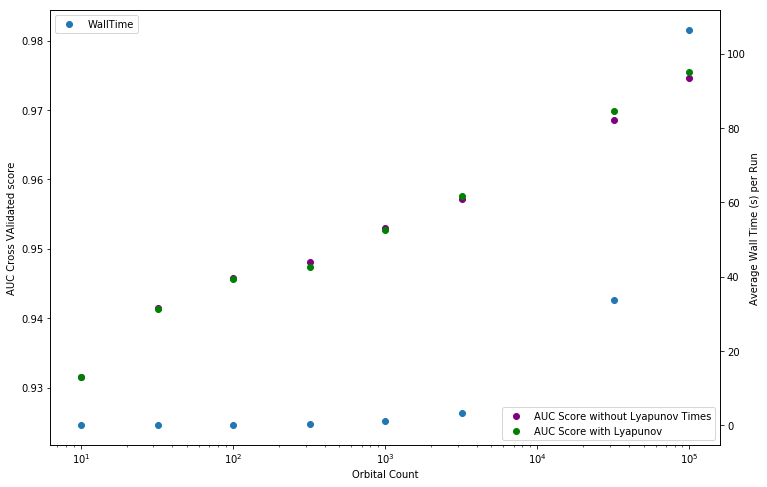

In [43]:
#graph it
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot("111")
#@ax.set_xscale("log")
#ax.set_xscale("log")
ax2 = ax.twinx()
#ax2.set_xscale("log")

lyapunov_scores_t= lyapunov_scores_t.astype(float)
scores_t = scores_t.astype(float)
orbital_count_t = orbital_count_t.astype(float)
wall_time_t = wall_time_t.astype(float)

ax.scatter(orbital_count_t, scores_t, label="AUC Score without Lyapunov Times", color = "purple",)
ax.scatter(orbital_count_t, lyapunov_scores_t, label="AUC Score with Lyapunov", color = "green",)

ax2.scatter(orbital_count_t, wall_time_t, label = "WallTime")
ax.legend(loc = 4)
ax.set_xlabel("Orbital Count")
ax.set_ylabel("AUC Cross VAlidated score")
ax2.set_ylabel("Average Wall Time (s) per Run")
ax2.legend(loc = 2)
ax2.set_xscale("log")
plt.show()


In [50]:
#Data generation Time
#compare with orbital time above
print orbital_count_t, wall_time_t
data_order = np.loadtxt("/scratch/nhussain/Order.txt", dtype= str)
#print data_order
data_order2 = np.loadtxt("/scratch/nhussain/Order2.txt", dtype=str)
print data_order, data_order2
new_orbital_count = [10000, 100, 1000, 10, 32000, 3200, 320, 32]

[  1.00000000e+05   1.00000000e+03   1.00000000e+02   1.00000000e+01
   3.20000000e+04   3.20000000e+03   3.20000000e+02   3.20000000e+01] [  1.06463151e+02   1.05349710e+00   1.08198826e-01   1.57736752e-02
   3.38626975e+01   3.32008317e+00   3.36450020e-01   3.88529452e-02]
['More_Orbs10000_Nout100_wind10_Lwind10.csv'
 'More_Orbs100.0_Nout100_wind10_Lwind10.csv'
 'More_Orbs1000_Nout100_wind10_Lwind10.csv'
 'More_Orbs10.0_Nout100_wind10_Lwind10.csv'
 'More_Orbs32000_Nout100_wind10_Lwind10.csv'
 'More_Orbs3200_Nout100_wind10_Lwind10.csv'
 'More_Orbs320_Nout100_wind10_Lwind10.csv'
 'More_Orbs32_Nout100_wind10_Lwind10.csv'] ['More_Lya_Orbs10000_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs100.0_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs1000_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs10.0_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs32000_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs3200_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs320_Nout100_wind10_Lwind10.csv'
 'More_Lya_Orbs32_Nout100_wind1

10.210909605 0.357589757443
0.17547454834 0.0441963672638
0.950809144975 0.0610474824905
0.126277780533 0.060782122612
33.785498333 0.854673087597
3.66973872185 0.151382791996
0.391623353958 0.0511899113655
0.0472154140472 0.0196197152138


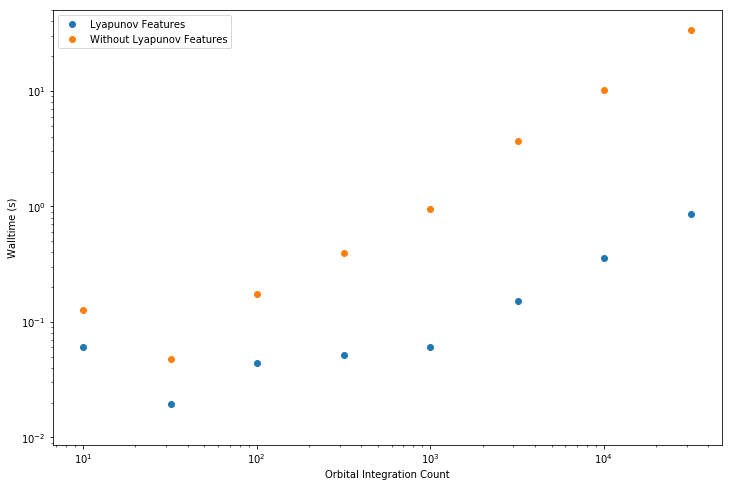

In [71]:
gen_time_lya = np.zeros(len(new_orbital_count))
gen_time_beta_feats = np.zeros_like(gen_time_lya)
for i in range(len(new_orbital_count)):
    lya_name = data_order2[i]
    name = data_order[i]
    lya_data = pd.read_csv("/scratch/nhussain/"+lya_name, index_col = 0)
    data = pd.read_csv("/scratch/nhussain/"+name, index_col = 0)
    print np.mean(lya_data["wall_time"]), np.mean(data["wall_time"])
    gen_time_lya[i] = np.mean(lya_data["wall_time"])
    gen_time_beta_feats[i] = np.mean(data["wall_time"])
fig = plt.figure(figsize  = (12, 8))
ax = fig.add_subplot("111")
ax.scatter(new_orbital_count, gen_time_beta_feats, label = "Lyapunov Features")
ax.scatter(new_orbital_count, gen_time_lya, label = "Without Lyapunov Features")
ax.set_yscale("log")
ax.set_xscale("log")
plt.legend()
#ax.scatter(orbital_count_t, wall_time_t, label = "feats")
ax.set_xlabel("Orbital Integration Count")
ax.set_ylabel("Walltime (s)")
plt.show()


In [7]:
#try with train test split
recall_vals_scaled = np.zeros_like(data_list)
recall_vals2_scaled= np.zeros_like(data_list)
orbital_count_scaled =  np.zeros_like(data_list)
#print features2
wall_time_scaled =  np.zeros_like(data_list)


print len(data_list)

#min_child_w = 3
#n_est=100
#max_d = 8
#learning_r = 0.01
#param = {'max_depth':8, 'eta':0.01, 'min_child_w':3 }
#https://datascience.stackexchange.com/questions/8032/how-to-predict-probabilities-in-xgboost

threshold = 0
start = time.time()

for i, name in enumerate(data_list):
    
    try:
        data = pd.read_csv(path_name + name, index_col = 0)
        Y = data["Stable"]
        #generate feature list
        X = data[features2]

        trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, Y,random_state = 0, stratify = Y, test_size = 0.2)
        dtrain = xgb.DMatrix(trainX, label = trainY)
        dtest = xgb.DMatrix(testX, label = testY)
        bst = xgb.train(params, dtrain)
        preds_proba = bst.predict(dtest)

        #score =sklearn.metrics.average_precision_score(testY, preds)
        #print "AUC Score", score
        precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba)
        for j, vals in enumerate(precision):
            if vals >= 0.900:
                #print recall, thresholds
                #print recall[j]
                recall_vals_scaled[i] = recall[j]
                #threshold = thresholds[j]
                print j, recall_vals_scaled[i], thresholds[j], vals
                #print recall_vals_scaled[i], thresholds[j], vals
                break
        #print recall_vals_scaled[i], threshold
    except Exception as e:
        print e
        recall_vals_scaled[i]=0.

    X = data[features]
    trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, Y,random_state = 0, stratify = Y, test_size = 0.2)
    #trainX, testX = trainX[features], testX[features]
    
    dtrain = xgb.DMatrix(trainX, label = trainY)
    dtest = xgb.DMatrix(testX, label = testY)
    bst = xgb.train(params, dtrain)       
    preds_proba = bst.predict(dtest)
 
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba)
    #plt.plot(precision, recall)
    for j, vals in enumerate(precision):
        if vals >= 0.900:
            #print recall, thresholds
            recall_vals2_scaled[i] = recall[j]
            threshold = thresholds[j]
            #break

            print recall_vals2_scaled[i], thresholds[j], vals
            break
    #print recall_vals2_scaled[i], threshold
    #cPickle.dump(bst ,open("/scratch/nhussain/Trained_XGBModels/cPickle_No_Lya_Booster_Orb_"+name.split("=")[1].split(".")[0]+".pkl", 'wb'))
    np.save('/scratch/nhussain/Trained_XGBModels/Numpy_No_Lya_Booster_'+name.split("=")[1].split(".")[0] + ".npy", bst)
    orbital_count_scaled[i]=float(name.split("=")[1].split(".")[0])
    wall_time_scaled[i]=( np.mean(data["wall_time"]))



end = time.time()
print "Time Taken",  (end - start)

9
"['Lyapunov_time'] not in index"
0.912714429869 0.504765 0.9
551 0.926841574168 0.499071 0.90004899559
0.928859737639 0.499652 0.900244498778
820 0.809283551968 0.513674 0.900112233446
0.805751765893 0.514649 0.900225479143
1090 0.764379414733 0.517168 0.902860548272
0.773965691221 0.517645 0.901822457378
729 0.706861755802 0.520914 0.900385604113
0.705852674067 0.521017 0.900837089504
367 0.892028254289 0.503263 0.901580826109
0.878910191726 0.505048 0.900723888314
653 0.809283551968 0.514145 0.900112233446
0.814833501514 0.513733 0.90022296544
678 0.765893037336 0.519111 0.900355871886
0.769424823411 0.517823 0.90076786769
933 0.749747729566 0.52175 0.900060569352
0.749747729566 0.52175 0.900060569352
Time Taken 201.536079884


In [88]:
#xgb.plot_tree(feature_names = features, model = bst, n_first_tree = 1)
#xgb.plot_tree(bst, plot_height = 8, plot_width = 12)
xgb.plot_tree(bst, num_trees = 1)
#xgb.plot_tree(bst, num_trees=2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(350, 200)
fig.savefig('../Figures/Presentation/tree3.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


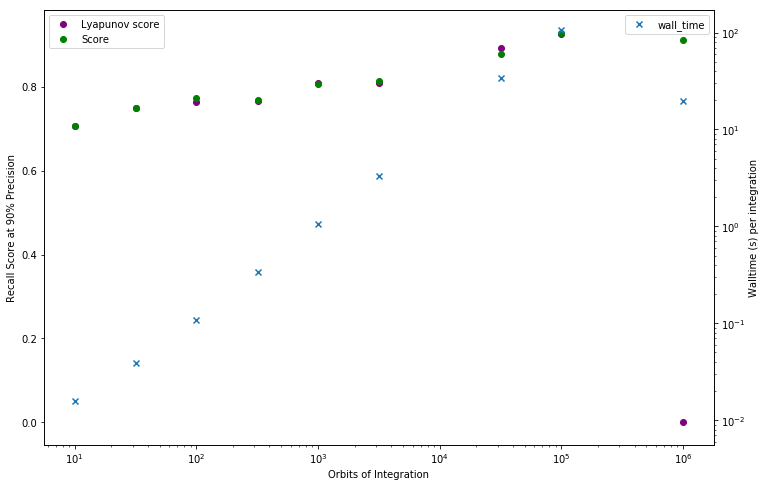

In [89]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot("111")

orbital_count = orbital_count_scaled.astype(float)
wall_time = wall_time_scaled.astype(float)
recall_vals = recall_vals_scaled.astype(float)
recall_vals2 = recall_vals2_scaled.astype(float)
ax1.scatter(orbital_count, recall_vals, color = "purple", label = "Lyapunov score")
ax1.scatter(orbital_count, recall_vals2, color = "green", label = "Score")

ax2= ax1.twinx()
ax2.scatter(orbital_count, wall_time, label = "wall_time", marker = "x")

ax1.set_xlabel("Orbits of Integration")
ax2.set_ylabel("Walltime (s) per integration")
ax1.set_ylabel("Recall Score at 90% Precision")
ax1.legend(loc = 0)
ax2.legend(loc = 1)
#fig.savefig("../Figures/ScoresAt90PrecisionShortIntegration.png")
ax1.set_xscale("log")
#plt.xscale('log')
#plt.xscale('log')
ax2.set_yscale("log")



Try with the Constant Nout Data, and see  how wall time changes with a Constant 100 10 10, so there is more similar overhead, and the walltime is soley affected by Norbits

In [90]:
#try comparing performace over a wider timescale
#See how performance drops for a given set of features:
path_name = "../csvs/ConstantNout/"
data_list = np.loadtxt(path_name+"Order.txt", dtype = str)


print data_list

['sifOrbs=1000.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=100.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=10.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=3200.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=320.0Nout=100window=10lyapwindow=10.csv'
 'sifOrbs=32.0Nout=100window=10lyapwindow=10.csv']


In [91]:
#print type(bst), type(model2)
#<class 'xgboost.core.Booster'> <class 'xgboost.sklearn.XGBClassifier'>
testing = pickle.load(open("/scratch/nhussain/Trained_XGBModels/No_Lya_Booster_Orb_100000.pkl"))
testing.predict(dtest)

IOError: [Errno 2] No such file or directory: '/scratch/nhussain/Trained_XGBModels/No_Lya_Booster_Orb_100000.pkl'

In [ ]:
#try comparing performace over a wider timescale
#See how performance drops for a given set of features:
path_name = "../csvs/LargeTimeScaleRange/"
#data_list = os.listdir(path_name)
data_list = np.loadtxt(path_name+"Order.txt", dtype = str)
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features2= features[:] + ['Lyapunov_time']
print data_list



#try with train test split
recall_vals_const = np.zeros_like(data_list)
recall_vals2_const= np.zeros_like(data_list)
orbital_count_const =  np.zeros_like(data_list)
#print features2
wall_time_const =  np.zeros_like(data_list)

start = time.time()




for i, name in enumerate(data_list):
    
    data = pd.read_csv(path_name + name, index_col = 0)
    Y = data["Stable"]
    #generate feature list
    X = data[features2]
  
    trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, Y,random_state = 0, stratify = Y, test_size = 0.2)
    dtrain = xgb.DMatrix(trainX, label = trainY)
    dtest = xgb.DMatrix(testX, label = testY)
    bst = xgb.train(params, dtrain)
    preds_proba = bst.predict(dtest)
    
    #score =sklearn.metrics.average_precision_score(testY, preds)
    #print "AUC Score", score
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba)
    for j, vals in enumerate(precision):
        if vals > 0.90:
            #print recall, thresholds
            recall_vals_const[i] = recall[j]
            print recall_vals_const[i], thresholds[j], vals
            break
    

    trainX, testX = trainX[features], testX[features]
    
    dtrain = xgb.DMatrix(trainX, label = trainY)
    dtest = xgb.DMatrix(testX, label = testY)
    bst = xgb.train(params, dtrain)       
    preds_proba = bst.predict(dtest)
 
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba)
    for j, vals in enumerate(precision):
        if vals > 0.900:
            #print recall, thresholds
            recall_vals2_const[i] = recall[j]
            print recall_vals2_const[i], thresholds[j], vals
            break
    #pickle.dump(model2 ,open("/scratch/nhussain/Trained_XGBModels/TrainedXGBmodel_Orb_"+name.split("=")[1].split(".")[0]+".pkl", 'wb'))
    orbital_count_const[i]=float(name.split("=")[1].split(".")[0])
    wall_time_const[i]=( np.mean(data["wall_time"]))

end = time.time()
print "Time Taken",  (end - start)

In [ ]:
#graph it

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot("111")
print orbital_count
print wall_time
print recall_vals
print recall_vals2

orbital_count = orbital_count_const.astype(float)
wall_time = wall_time_const.astype(float)
recall_vals = recall_vals_const.astype(float)
recall_vals2 = recall_vals2_const.astype(float)



ax1.scatter(orbital_count, recall_vals, color = "purple", label = "Lyapunov score")
ax1.scatter(orbital_count, recall_vals2, color = "green", label = "Score")

ax2= ax1.twinx()
ax2.scatter(orbital_count, wall_time, label = "wall_time", marker = "x")

ax1.set_xlabel("Orbits of Integration at Constant 100 Nout.")
ax2.set_ylabel("Walltime (s) per integration")
ax1.set_ylabel("Recall Score at 90% Precision")
ax1.legend(loc = 0)
ax2.legend(loc = 2)
#fig.savefig("../Figures/ScoresAt90PrecisionShortIntegration.png")
ax1.set_xscale("log")
#plt.xscale('log')
#plt.xscale('log')





In [ ]:
#graph it

fig = plt.figure(figsize = (14, 9))
ax1 = fig.add_subplot("111")
print orbital_count
print wall_time
print recall_vals
print recall_vals2

orbital_count = orbital_count_scaled.astype(float)
wall_time = wall_time_scaled.astype(float)
recall_vals = recall_vals_scaled.astype(float)
recall_vals2 = recall_vals2_scaled.astype(float)

orbital_count_c = orbital_count_const.astype(float)
wall_time_c = wall_time_const.astype(float)
recall_vals_c = recall_vals_const.astype(float)
recall_vals2_c = recall_vals2_const.astype(float)





ax1.scatter(orbital_count, recall_vals, color = "purple", label = "Lyapunov score - Scaled Nout")
ax1.scatter(orbital_count, recall_vals2, color = "green", label = "Score - Scaled Nout")
ax1.scatter(orbital_count_c, recall_vals_c, color = "purple", label = "Lyapunov score - Constant Nout", marker="x")
ax1.scatter(orbital_count_c, recall_vals2_c, color = "green", label = "Score - Constant Nout", marker="x")


ax2= ax1.twinx()
ax2.scatter(orbital_count, wall_time, label = "Wall_time - Scaled Nout", color = "orange")
ax2.scatter(orbital_count_c, wall_time_c, label = "Wall_time - Constant Nout", marker = "x", color = "orange")


ax1.set_xlabel("Orbits of Integration")
ax2.set_ylabel("Walltime (s) per integration")
ax1.set_ylabel("Recall Score at 90% Precision")
ax1.legend(loc = 1)
ax2.legend(loc = 2)
#fig.savefig("../Figures/ComparisionScores.png")
ax1.set_xscale("log")
ax2.set_yscale("log")
#plt.xscale('log')
#plt.xscale('log')





Try with sklearn wrapper, compare time difference

In [ ]:
#try comparing performace over a wider timescale
#See how performance drops for a given set of features:
path_name = "../csvs/LargeTimeScaleRange/"
#data_list = os.listdir(path_name)
data_list = np.loadtxt(path_name+"Order.txt", dtype = str)
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
features2= features[:] + ['Lyapunov_time']

print data_list

#try with train test split
recall_vals_scaled = np.zeros_like(data_list)
recall_vals2_scaled= np.zeros_like(data_list)
orbital_count_scaled =  np.zeros_like(data_list)
#print features2
wall_time_scaled =  np.zeros_like(data_list)


print len(data_list)

min_child_w = 3
n_est=100
max_d = 8
learning_r = 0.01
model_sk = xgb.XGBClassifier(min_child_weight=min_child_w, n_estimators=n_est, max_depth=max_d, learning_rate=learning_r)
print type(model_sk)
#https://datascience.stackexchange.com/questions/8032/how-to-predict-probabilities-in-xgboost

start = time.time()

for i, name in enumerate(data_list):
    
    data = pd.read_csv(path_name + name, index_col = 0)
    Y = data["Stable"]
    #generate feature list
    X = data[features2]
  
    trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, Y,random_state = 0, stratify = Y, test_size = 0.2)
  
    start_1 = time.time()
    model_sk.fit(trainX, trainY)
    end_t = time.time()
    print "time", end_t - start_1
    preds_proba = model_sk.predict_proba(testX)[:,1]
    print preds_proba.shape

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba)
    for j, vals in enumerate(precision):
        if vals >= 0.900:
  
            recall_vals_scaled[i] = recall[j]
            print j, recall_vals_scaled[i], thresholds[j], vals
            break

    trainX, testX = trainX[features], testX[features]
   
    model_sk.fit(trainX, trainY)
    preds_proba = model_sk.predict_proba(testX)[:, 1]
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba)
    #plt.plot(precision, recall)
    for j, vals in enumerate(precision):
        if vals >= 0.900:
            #print recall, thresholds
            recall_vals2_scaled[i] = recall[j]
            threshold = thresholds[j]
            #break

            print recall_vals2_scaled[i], thresholds[j], vals
            break
    #print recall_vals2_scaled[i], threshold
    pickle.dump(model_sk ,open("/scratch/nhussain/Trained_XGBModels/No_Lya_Model_Orb_"+name.split("=")[1].split(".")[0]+".pkl", 'wb'))
    orbital_count_scaled[i]=float(name.split("=")[1].split(".")[0])
    wall_time_scaled[i]=( np.mean(data["wall_time"]))



end = time.time()
print "Time Taken",  (end - start)

#try with data thats a scaled down version of running 10000 orbits   with Nout = 100, and bothe windows are 20

In [ ]:
#See how performance drops for a given set of features:
path_name = "../csvs/ShortTimeScale/"
#data_list = os.listdir(path_name)
data_list = np.loadtxt(path_name+"Order.txt", dtype = str)
features = []
features += ['avg_iH1', 'avg_iH2']
features += ['norm_std_a1', 'norm_max_a1']#, 'norm_std_window10_a1', 'norm_max_window10_a1']
features += ['norm_std_a2', 'norm_max_a2']#, 'norm_std_window10_a2', 'norm_max_window10_a2']
features += ['norm_std_a3', 'norm_max_a3']#, 'norm_std_window10_a3', 'norm_max_window10_a3']
features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
print data_list

In [ ]:
#define the parametsr and model
min_child_w = 3
n_est=100
max_d = 8
learning_r = 0.01
model2 = xgb.XGBClassifier(min_child_weight=min_child_w, n_estimators=n_est, max_depth=max_d, learning_rate=learning_r)
params = model2.get_xgb_params()


In [ ]:
#print vals        
orbital_count = np.zeros(len(data_list))

wall_time3 = np.zeros_like(orbital_count)
scores3 = np.zeros_like(orbital_count)


for i, name in enumerate(data_list):
    data = pd.read_csv(path_name + name, index_col = 0)
    Y = data["Stable"]
    #generate feature list
    used_features = features[:]
    for feats in data.columns.values:
        if "window" in feats:
            used_features.append(feats) 
    X = data[used_features]
    
    #print data.shape
    dtrain = xgb.DMatrix(X, label = Y)
    #dtrain = xgb.DMatrix(X_vals[i], label=Y_vals[i])
    score = xgb.cv(params, dtrain, metrics = "auc", nfold=5, verbose_eval=True)
    # cross_val_score(estimator=model2, n_jobs=-1, cv = 5, X = X_vals[i], y = Y_vals[i], scoring ='average_precision', verbose = 5)
    print np.mean(score['test-auc-mean'])    #scores.append(score)
    scores3[i]=(np.mean(score['test-auc-mean']))
    wall_time3[i]=( np.mean(data["wall_time"]))
    orbital_count[i]=float(name.split("=")[1].split(".")[0])
    print orbital_count
    

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot("111")
ax1.scatter(orbital_count, scores3, color = "purple", label = "score")
p1 = ax2= ax1.twinx()
p2 = ax2.scatter(orbital_count, wall_time3, label = "wall_time", marker = "x")
#ax1.scatter(np.nan,np.nan,  marker = "x", color ="blue",  label = 'wall_time', s = 20)
#fig.legend(center)
#p_t = p1 +p2
#legend_labels = [x.get_label() for x in p_t]
#ax.legend(p_t, legend_labels, loc=0)
ax1.set_xlabel("Orbits of Integration")
ax2.set_ylabel("Walltime (s) per integration")
ax1.set_ylabel("AUC Crossvalidated Score")
ax1.legend(loc = 0)
ax2.legend(loc = 2)

Redo this with the above dataset, but with just one train test split as we want to see what kind of recall we retain with 90% precision

In [ ]:
#print vals        
precision_vals = np.zeros_like(data_list)
recall_vals = np.zeros_like(data_list)
#wall_time3 = np.zeros_like(orbital_count)
#scores3 = np.zeros_like(orbital_count)
orbital_count = np.zeros(len(data_list))
wall_time3 = np.zeros_like(data_list)



for i, name in enumerate(data_list):
    threshold = 0
    data = pd.read_csv(path_name + name, index_col = 0)
    Y = data["Stable"]
    #generate feature list
    used_features = features[:]
    for feats in data.columns.values:
        if "window" in feats:
            used_features.append(feats) 
    X = data[used_features]
    #create a stratified 0.8 0.2 split
    trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, Y,random_state = 0, stratify = Y, test_size = 0.2)
    model2.fit(trainX, trainY)
    preds = model2.predict(testX)
    preds_proba = model2.predict_proba(testX)
    score =sklearn.metrics.average_precision_score(testY, preds)
    print "AUC Score", score
    wall_time3[i]=( np.mean(data["wall_time"]))
    orbital_count[i]=float(name.split("=")[1].split(".")[0])
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba[:,1])
    for j, vals in enumerate(reversed(list(precision))):
        if vals > 0.9:
            #print recall, thresholds
            recall_vals[i] = recall[j]
            precision_vals[i] = precision[j]
            threshold = thresholds[j]
    print recall_vals[i], precision_vals[i] , threshold
            
print recall_vals, precision_vals
    

In [ ]:


fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot("111")
ax1.scatter(orbital_count[:len(recall_vals)], recall_vals, color = "purple", label = "score")
p1 = ax2= ax1.twinx()
p2 = ax2.scatter(orbital_count[:len(recall_vals)], wall_time3, label = "wall_time", marker = "x")
#ax1.scatter(np.nan,np.nan,  marker = "x", color ="blue",  label = 'wall_time', s = 20)
#fig.legend(center)
#p_t = p1 +p2
#legend_labels = [x.get_label() for x in p_t]
#ax.legend(p_t, legend_labels, loc=0)
ax1.set_xlabel("Orbits of Integration")
ax2.set_ylabel("Walltime (s) per integration")
ax1.set_ylabel("Recall Score at 90% Precision")
ax1.legend(loc = 0)
ax2.legend(loc = 2)
fig.savefig("../Figures/ScoresAt90PrecisionShortIntegration.png")

In [ ]:
#print vals        
precision_vals = np.zeros_like(data_list)
recall_vals = np.zeros_like(data_list)
#wall_time3 = np.zeros_like(orbital_count)
#scores3 = np.zeros_like(orbital_count)
orbital_count = np.zeros(len(data_list))
wall_time3 = np.zeros_like(data_list)



for i, name in enumerate(data_list):
    data = pd.read_csv(path_name + name, index_col = 0)
    Y = data["Stable"]
    #generate feature list
    used_features = features[:]
    for feats in data.columns.values:
        if "window" in feats:
            used_features.append(feats) 
    X = data[used_features]
    #create a stratified 0.8 0.2 split
    trainX, testX, trainY, testY = sklearn.model_selection.train_test_split(X, Y,random_state = 0, stratify = Y, test_size = 0.2)
    model2.fit(trainX, trainY)
    preds = model2.predict(testX)
    preds_proba = model2.predict_proba(testX)
    score =sklearn.metrics.average_precision_score(testY, preds)
    print "AUC Score", score
    wall_time3[i]=( np.mean(data["wall_time"]))
    orbital_count[i]=float(name.split("=")[1].split(".")[0])
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds_proba[:,1])
    for j, vals in enumerate(precision):
        if vals >= 0.9:
            #print recall, thresholds
            recall_vals[i] = recall[j]
            precision_vals[i] = precision[j]
            print recall_vals[i], precision_vals[i] , vals
            break
print recall_vals, precision_vals
    

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot("111")
ax1.scatter(orbital_count, recall_vals, color = "purple", label = "score")
p1 = ax2= ax1.twinx()
p2 = ax2.scatter(orbital_count, wall_time3, label = "wall_time", marker = "x")
#ax1.scatter(np.nan,np.nan,  marker = "x", color ="blue",  label = 'wall_time', s = 20)
#fig.legend(center)
#p_t = p1 +p2
#legend_labels = [x.get_label() for x in p_t]
#ax.legend(p_t, legend_labels, loc=0)
ax1.set_xlabel("Orbits of Integration")
ax2.set_ylabel("Walltime (s) per integration")
ax1.set_ylabel("Recall Score at 90% Precision")
ax1.legend(loc = 0)
ax2.legend(loc = 2)
fig.savefig("../Figures/ScoresAt90PrecisionShortIntegration.png")